In [3]:
import bagpy
from bagpy import bagreader
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from functools import reduce
from scipy.spatial.transform import Rotation
import ipympl

%matplotlib widget

sns.set_theme()
# LaTex must be installed for this to work
# sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended cm-super

plt.rcParams['text.usetex'] = True
plt.rc('text.latex', preamble=r'\usepackage{bm}')

In [69]:
def drop_columns_in_df(df):
    return df.drop(columns=["header.seq", "header.stamp.secs", "header.stamp.nsecs", "header.frame_id"])

def rename_columns(df, new_colum_names: list):
    column_names = ['Time'] + new_colum_names
    
    df.columns= column_names

    return df

def normalize_df_time(df):
    start_time = df['Time'].iloc[0]

    df['Time'] -= start_time

    return df

def sync_dfs_based_on_time(dataframes: list):
    df_merged = reduce(lambda left,right: pd.merge_asof(left, right, on="Time", allow_exact_matches=True, direction="nearest", tolerance=0.01), dataframes)

    return df_merged

def df_from_pose_to_euler(df):
    quat_df = df[['pose.orientation.x', 'pose.orientation.y', 'pose.orientation.z', 'pose.orientation.w']]
    rot = Rotation.from_quat(quat_df)
    rot_euler = rot.as_euler('xyz', degrees=True)
    euler_df = pd.DataFrame(data=rot_euler, columns=['roll', 'pitch', 'yaw'])

    conc = [df, euler_df]

    df_gt_euler = pd.concat(
        conc,
        axis=1,
        join="outer",
        ignore_index=False,
        keys=None,
        levels=None,
        names=None,
        verify_integrity=False,
        copy=True,
    )

    df_gt_euler = drop_columns_in_df(df_gt_euler)
    df_gt_euler.drop(columns=["pose.position.x", "pose.position.y", "pose.position.z", "pose.orientation.x", "pose.orientation.y","pose.orientation.z","pose.orientation.w"], inplace=True)

    return df_gt_euler

def Mask_Or_Drop_Successive_Identical_Values(df, drop=False, 
                                             keep_first=True,
                                             axis=0):

    '''
    Input:
    df should be a pandas.DataFrame of a a pandas.Series
    Output:
    df of ts with masked or dropped values
    '''
    
    # Mask keeping the first occurrence
    if keep_first:
        df = df.mask(df.shift(1) == df)
    # Mask including the first occurrence
    else:
        df = df.mask((df.shift(1) == df) | (df.shift(-1) == df))

    # Drop the values (e.g. rows are deleted)    
    if drop:
        return df.dropna(axis=axis)        
    # Only mask the values (e.g. become 'NaN')
    else:
        return df

def get_np_arr_without_nan(df, datacols_list, remove_identicals=True):
    if remove_identicals:
      df_with_NAN = Mask_Or_Drop_Successive_Identical_Values(df)
    else:
      df_with_NAN = df

    column_names = ['Time'] + datacols_list

    selected_rows = df_with_NAN[~df_with_NAN[datacols_list[0]].isnull()]
    reduced_df_without_NAN = selected_rows[column_names]

    return reduced_df_without_NAN.to_numpy()

def ret_track_df(df):
    # create an empty list to store DataFrames
    dfs = []

    # iterate over rows of the original DataFrame
    for index, row in df.iterrows():
        # split the bounding boxes string into individual boxes
        bbs = row['bbs'].replace('[','').replace(']','').split(', ')
        # create a DataFrame for each box and append it to the list of DataFrames
        for bb in bbs:
            bb_dict = {}
            for item in bb.split("\n"):
                key, value = item.split(": ")
                bb_dict[key.strip()] = float(value) if key.strip() not in ["id", "Class"] else value.strip().replace('"', '')
            new_row = {**row.to_dict(), **bb_dict}
            dfs.append(pd.DataFrame(new_row, index=[index]))

    # concatenate the list of DataFrames into a single DataFrame
    new_df = pd.concat(dfs, axis=0, ignore_index=True)

    new_df = new_df[["Time", "probability",	"xmin",	"ymin",	"xmax",	"ymax",	"id",	"Class"]]

    new_df['id'] = new_df['id'].astype(int)

    # extract the desired columns using loc
    new_df = new_df.loc[:, ['Time', 'id', 'probability', 'Class', 'xmin', 'ymin', 'xmax', 'ymax']]

    # calculate the center x and y coordinates
    new_df['center_x'] = (new_df['xmin'] + new_df['xmax']) / 2
    new_df['center_y'] = (new_df['ymin'] + new_df['ymax']) / 2

    # drop the original xmin, ymin, xmax, ymax columns
    new_df.drop(columns=['xmin', 'ymin', 'xmax', 'ymax'], inplace=True)

    return new_df


In [5]:
GNSS_body_1hz = True
GNSS_ned = True

## Load bagfile

In [86]:
b = bagreader('/home/msccomputer/catkin_ws/src/msc_thesis/test_tools/scripts/live_rosbaging/rosbags/test_PT/offline/test1/2023-03-29-14-39-37.bag')

b.topic_table

[INFO]  Successfully created the data folder /home/msccomputer/catkin_ws/src/msc_thesis/test_tools/scripts/live_rosbaging/rosbags/test_PT/offline/test1/2023-03-29-14-39-37.


,Topics,Types,Message Count,Frequency
0,/anafi/attitude,geometry_msgs/QuaternionStamped,3379,32.990557
1,/anafi/gnss_location,sensor_msgs/NavSatFix,3379,32.945339
2,/anafi/gnss_ned_in_body_frame,geometry_msgs/PointStamped,3376,32.949221
3,/anafi/gnss_ned_in_body_frame/1hz,geometry_msgs/PointStamped,109,0.977811
4,/anafi/height,anafi_uav_msgs/Float32Stamped,3379,32.959578
5,/anafi/image,sensor_msgs/Image,3378,32.806445
6,/anafi/ned_pos_from_gnss,geometry_msgs/PointStamped,3378,33.003927
7,/anafi/optical_flow_velocities,geometry_msgs/Vector3Stamped,3379,32.894567
8,/anafi/polled_body_velocities,geometry_msgs/TwistStamped,558,4.983939
9,/anafi/pose,geometry_msgs/PoseStamped,3349,32.887345


## Read topics

In [87]:
if GNSS_body_1hz:
    gnss_position = b.message_by_topic('/anafi/gnss_ned_in_body_frame/1hz')
    df_gnss_position = pd.read_csv(gnss_position)

    df_gnss_position = drop_columns_in_df(df_gnss_position)

    df_gnss_position_body_1h = rename_columns(df_gnss_position, ["gnss_x_body", "gnss_y_body", "gnss_z_body"])


In [88]:
if GNSS_ned:
    gnss_position = b.message_by_topic('/anafi/ned_pos_from_gnss')
    df_gnss_position = pd.read_csv(gnss_position)

    df_gnss_position = drop_columns_in_df(df_gnss_position)

    df_gnss_position_ned = rename_columns(df_gnss_position, ["gnss_x_ned", "gnss_y_ned", "gnss_z_ned"])

df_gnss_position_ned

,Time,gnss_x_ned,gnss_y_ned,gnss_z_ned
0,1.679907e+09,-0.558102,-0.333416,5.574219
1,1.679907e+09,-0.558102,-0.333416,5.574219
2,1.679907e+09,-0.558102,-0.333416,5.574219
3,1.679907e+09,-0.558102,-0.333416,5.574219
4,1.679907e+09,-0.558102,-0.345324,5.566406
...,...,...,...,...
3373,1.679907e+09,1.328816,0.142893,-0.460937
3374,1.679907e+09,1.328816,0.142893,-0.460937
3375,1.679907e+09,1.328816,0.142893,-0.460937
3376,1.679907e+09,1.328816,0.142893,-0.460937


In [91]:
df_list = []
    
if GNSS_ned:
    df_list.append(df_gnss_position_ned)

if GNSS_body_1hz:
    df_list.append(df_gnss_position_body_1h)


df_merged_position = sync_dfs_based_on_time(df_list)
df_merged_position = normalize_df_time(df_merged_position)

if GNSS_ned:
    gnss_ned_data = get_np_arr_without_nan(df_merged_position, ["gnss_x_ned", "gnss_y_ned", "gnss_z_ned"], remove_identicals=False)

if GNSS_body_1hz:
    gnss_body_1hz_data = get_np_arr_without_nan(df_merged_position, ["gnss_x_body", "gnss_y_body", "gnss_z_body"], remove_identicals=False)



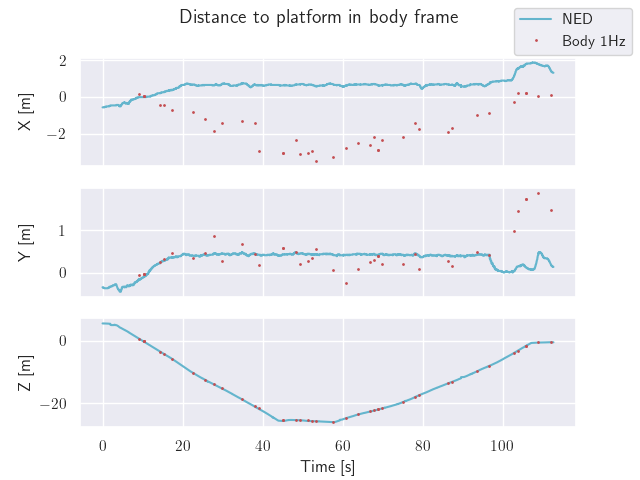

In [92]:
fig, axs = plt.subplots(3, 1)


axs[0].set_ylabel('X [m]')
axs[0].grid(True)
axs[0].set_xticklabels([])

axs[1].set_xticklabels([])
axs[1].set_ylabel('Y [m]')
axs[1].grid(True)
axs[1].set_xticklabels([])

axs[2].set_xlabel('Time [s]')
axs[2].set_ylabel('Z [m]')
axs[2].grid(True)


if GNSS_ned:
    axs[0].plot(gnss_ned_data[:,0], gnss_ned_data[:,1], c='c')
    axs[1].plot(gnss_ned_data[:,0], gnss_ned_data[:,2], c='c')
    axs[2].plot(gnss_ned_data[:,0], gnss_ned_data[:,3], c='c', label="NED")

if GNSS_body_1hz:
    axs[0].plot(gnss_body_1hz_data[:,0], gnss_body_1hz_data[:,1],'o', ms=1, c='r')
    axs[1].plot(gnss_body_1hz_data[:,0], gnss_body_1hz_data[:,2],'o', ms=1, c='r')
    axs[2].plot(gnss_body_1hz_data[:,0], -gnss_body_1hz_data[:,3],'o', ms=1, c='r', label="Body 1Hz")


handles, labels = axs[2].get_legend_handles_labels()
fig.legend(labels, loc='upper right', ncol=1)
fig.suptitle('Distance to platform in body frame', fontsize=14)
fig.align_ylabels(axs)

plt.show()
# plt.savefig("figures_mission/all_measurements.svg")


# Plot the attitude from the anafi

In [93]:
attitude_anafi = True

<AxesSubplot: xlabel='Time'>

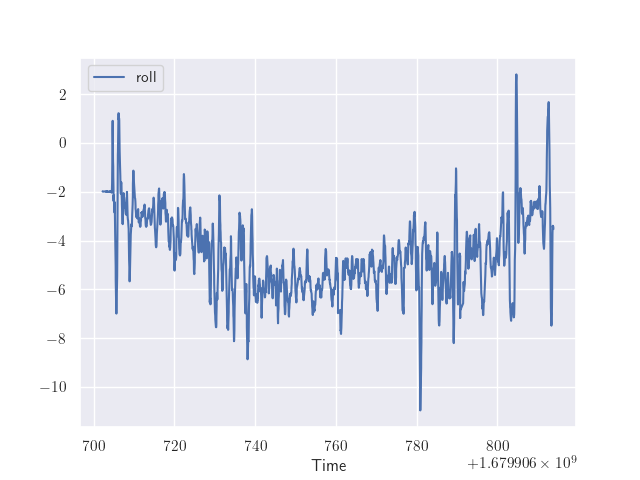

In [94]:
if attitude_anafi:
    anafi_attitude = b.message_by_topic('/anafi/pose')
    df_anafi_attitude = pd.read_csv(anafi_attitude)

    df_anafi_attitude = df_from_pose_to_euler(df_anafi_attitude)

    df_anafi_attitude = rename_columns(df_anafi_attitude, ["roll", "pitch", "yaw"])

df_anafi_attitude.plot(x="Time", y="roll")

In [97]:
df_list = []
    
if attitude_anafi:
    df_list.append(df_anafi_attitude)

df_merged_position = sync_dfs_based_on_time(df_list)
df_merged_position = normalize_df_time(df_merged_position)

if attitude_anafi:
    attitude_data = get_np_arr_without_nan(df_merged_position, ["roll", "pitch", "yaw"], remove_identicals=False)



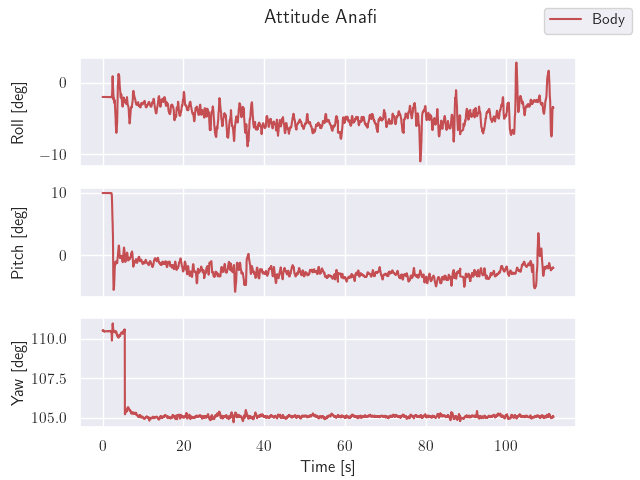

In [98]:
fig, axs = plt.subplots(3, 1)


axs[0].set_ylabel('Roll [deg]')
axs[0].grid(True)
axs[0].set_xticklabels([])

axs[1].set_xticklabels([])
axs[1].set_ylabel('Pitch [deg]')
axs[1].grid(True)
axs[1].set_xticklabels([])

axs[2].set_xlabel('Time [s]')
axs[2].set_ylabel('Yaw [deg]')
axs[2].grid(True)


if attitude_anafi:
    axs[0].plot(attitude_data[:,0], attitude_data[:,1], c='r')
    axs[1].plot(attitude_data[:,0], attitude_data[:,2], c='r')
    axs[2].plot(attitude_data[:,0], attitude_data[:,3], c='r', label="Body")


handles, labels = axs[2].get_legend_handles_labels()
fig.legend(labels, loc='upper right', ncol=1)
fig.suptitle('Attitude Anafi', fontsize=14)
fig.align_ylabels(axs)

plt.show()
# plt.savefig("figures_mission/all_measurements.svg")
